
---
## Read datasets

In [4]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

_X_train, _y_train = train['features'], train['labels']
_X_valid, _y_valid = valid['features'], valid['labels']
_X_test, _y_test = test['features'], test['labels']

## Dataset Analysis

Train Feature Shape : (34799, 32, 32, 3)
Valid Feature Shape : (4410, 32, 32, 3)
Test Feature Shape : (12630, 32, 32, 3)
Label Num: 43


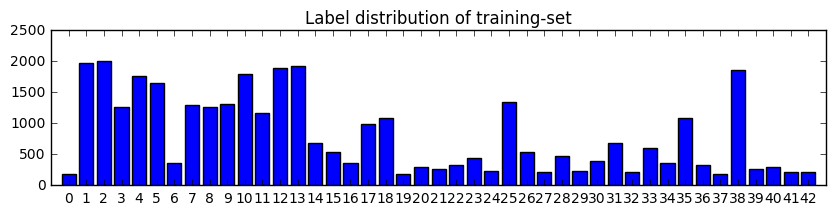

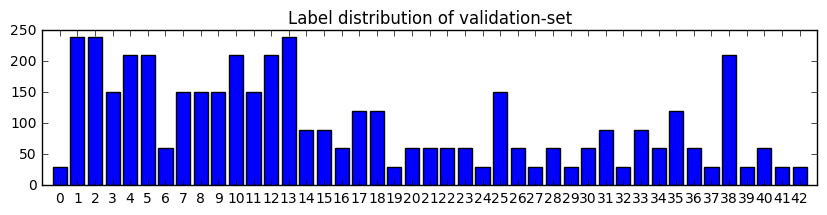

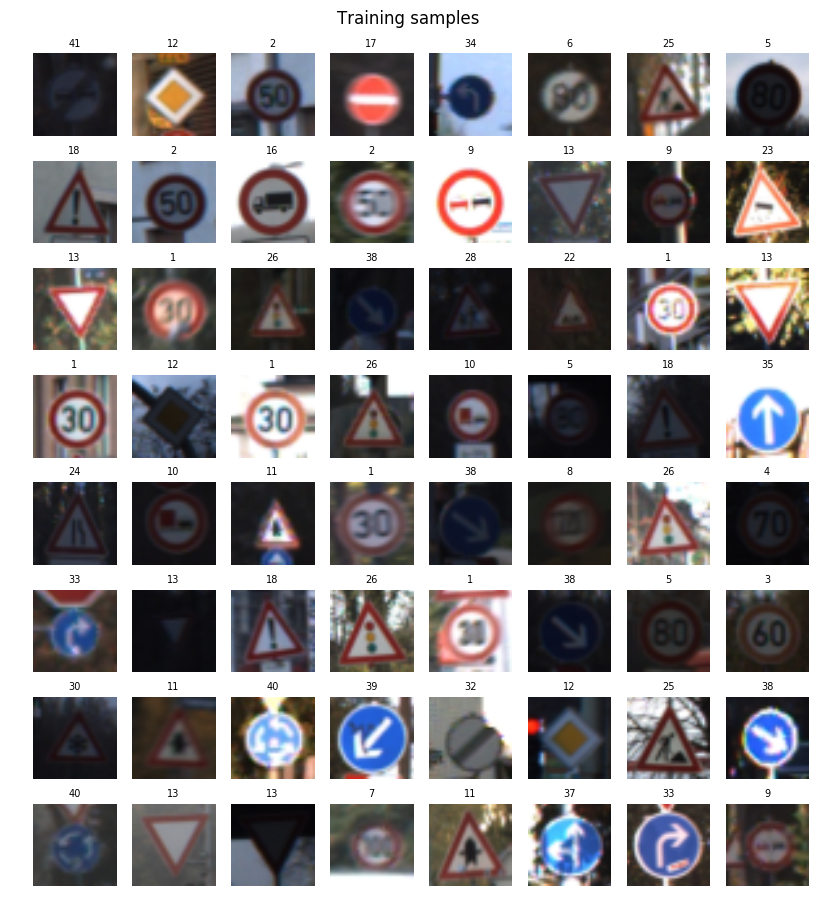

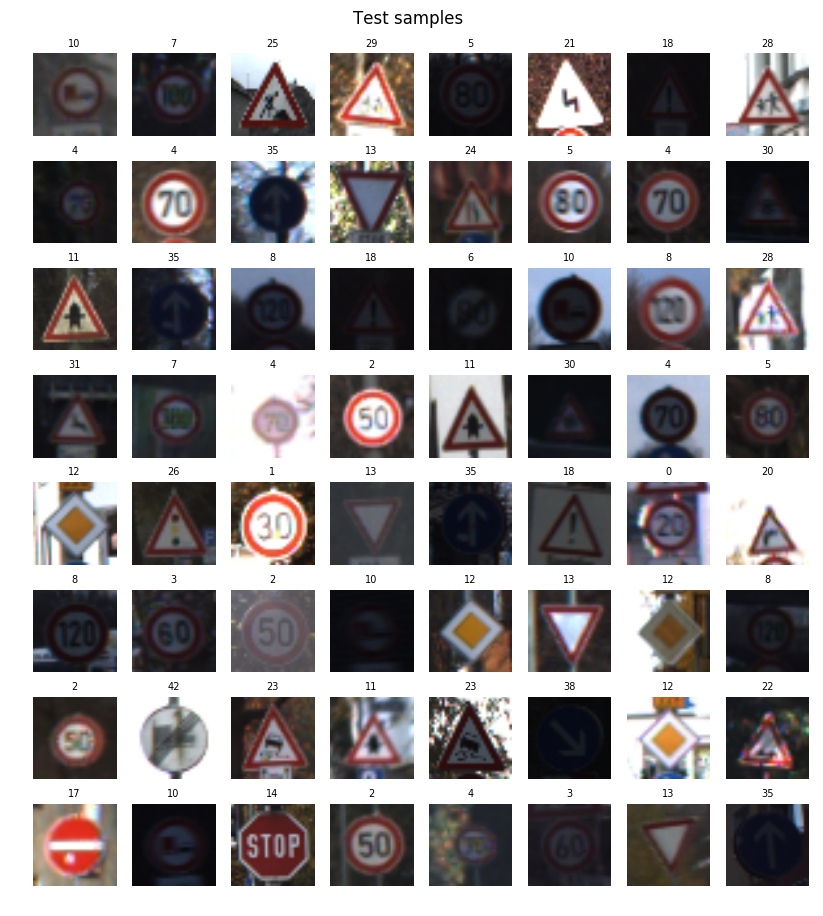

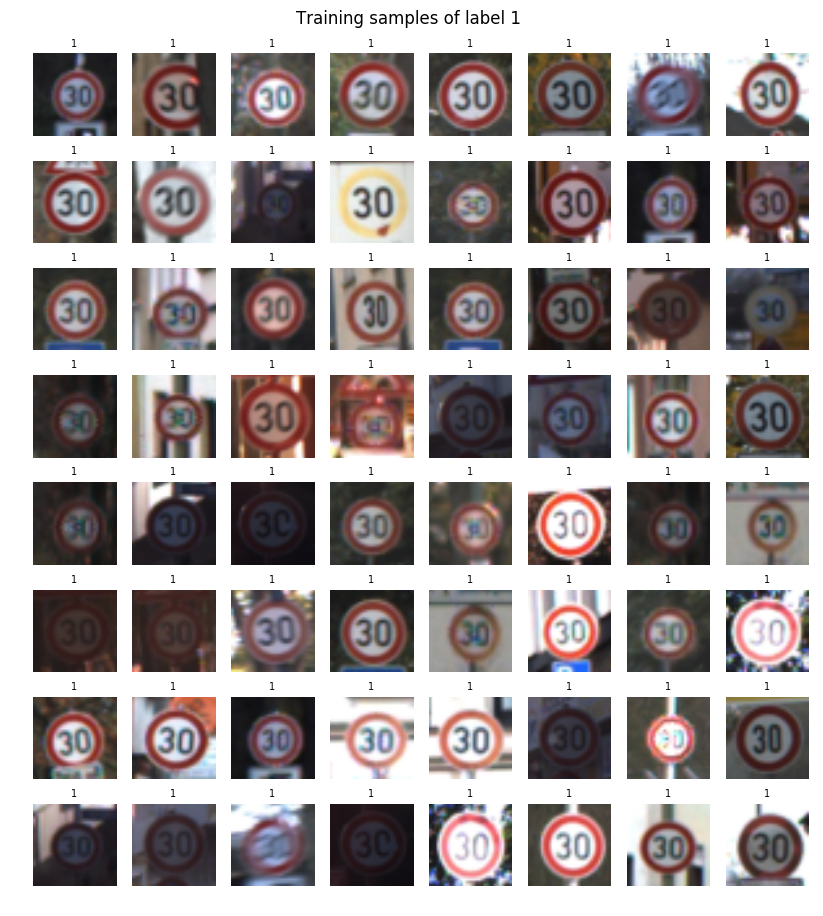

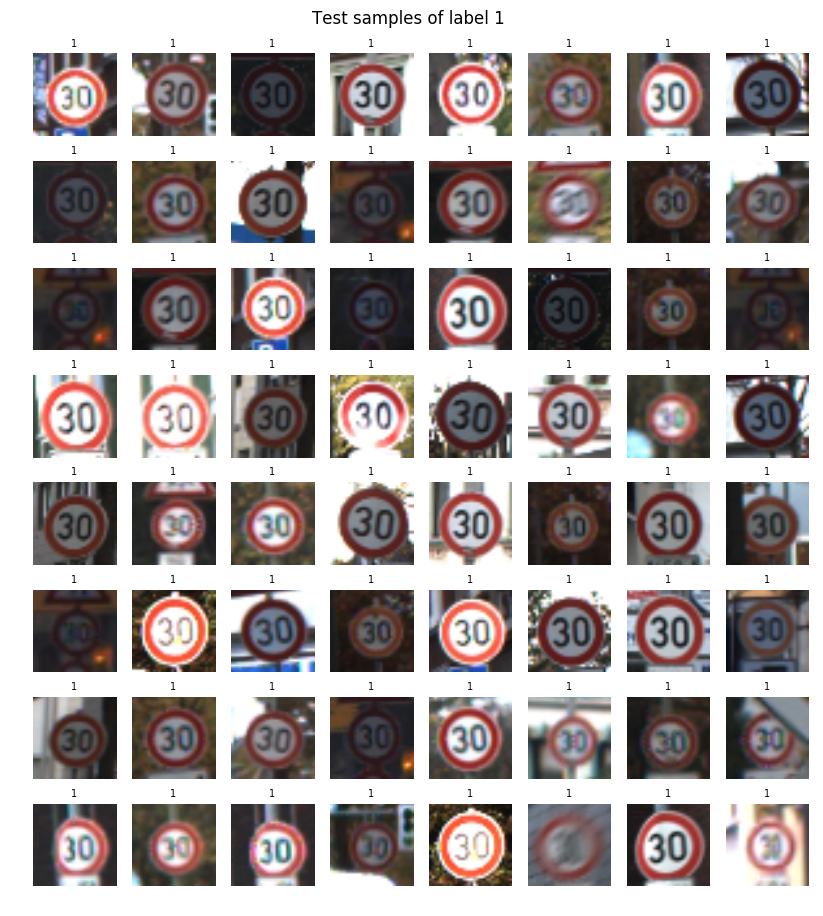

In [2]:
"""
data 분포 및 특성 확인
"""
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print('Train Feature Shape : {}'.format(_X_train.shape))
print('Valid Feature Shape : {}'.format(_X_valid.shape))
print('Test Feature Shape : {}'.format(_X_test.shape))

n_label = len(set(_y_train))
print("Label Num: {}".format(n_label))

def show_label_distribution(data, title=None):
    cnt_of_labels = np.bincount(data)
    index_list = range(len(cnt_of_labels))
    
    plt.figure(figsize=(10, 2))
    plt.bar(index_list, cnt_of_labels, tick_label=index_list, align='center')
    plt.xlim([-1,len(index_list)])
    if title:
        plt.title(title)
    plt.show()


def show_samples_from_all(images, labels, nb_grid=8, title=None):
    random_indices = [i for i in range(len(images))]
    np.random.shuffle(random_indices)
    images = images[random_indices]
    labels = labels[random_indices]

    fig, axes = plt.subplots(nb_grid, nb_grid, figsize=(10,10))
    fig.suptitle(title, fontsize=12)
    for i, start in enumerate(range(0, images.shape[0], int(images.shape[0]/nb_grid + 0.5))):
        end = start + nb_grid
        if end >= images.shape[0]:
            end -= images.shape[0]
        for j, (image, label) in enumerate(zip(images[start:end],labels[start:end])):
            axes[i,j].set_title(label, fontsize=7)
            axes[i,j].axis('off')
            axes[i,j].imshow(image)
    
    fig.subplots_adjust(top=0.94, bottom=0.1)
    plt.show()

    
def show_samples_from_one(images, labels, selected_idx=0, nb_grid=8, title=None):
    indices_of_label = [idx for idx, label in enumerate(labels) if label == selected_idx]
    images_of_label = images[indices_of_label]
    
    random_indices = [i for i in range(len(images_of_label))]
    np.random.shuffle(random_indices)
    images_of_label = images_of_label[random_indices]

    fig, axes = plt.subplots(nb_grid, nb_grid, figsize=(10,10))
    fig.suptitle(title, fontsize=12)
    for i, start in enumerate(range(0, images_of_label.shape[0], int(images_of_label.shape[0]/nb_grid + 0.5))):
        end = start + nb_grid
        if end >= images_of_label.shape[0]:
            end -= images_of_label.shape[0]
        for j, image in enumerate(images_of_label[start:end]):
            axes[i,j].set_title(selected_idx, fontsize=7)
            axes[i,j].axis('off')
            axes[i,j].imshow(image)
    
    fig.subplots_adjust(top=0.94, bottom=0.1)
    #plt.savefig('./traffic-signs-data/for_analysis/%d_test.png'%label_idx) # 이미지 저장용
    plt.show()
    
    
# show label distributions        
show_label_distribution(_y_train, 'Label distribution of training-set')
show_label_distribution(_y_valid, 'Label distribution of validation-set')

# show sub-samples from entire dataset
show_samples_from_all(_X_train, _y_train, title='Training samples')
show_samples_from_all(_X_test, _y_test, title='Test samples')

# show sub-samples of only the selected label
selected_label = 1
show_samples_from_one(_X_train, _y_train, selected_idx=1, title='Training samples of label {}'.format(selected_label))
show_samples_from_one(_X_test, _y_test, selected_idx=1, title='Test samples of label {}'.format(selected_label))

In [3]:
from keras.utils import np_utils

def data_normalization(*args):
    res = []
    
    for arg in args:
        arg = arg.astype('float32')
        n_channel = arg.shape[-1]

        if n_channel == 3:
            for i in range(len(arg)):
                for j in range(n_channel):
                    mean = np.mean(arg[i,:,:,j])
                    if mean != 0: 
                        arg[i,:,:,j] /= mean
                
        elif n_channel == 1:
            for i in range(len(arg)):
                mean = np.mean(arg[i])
                if mean != 0: 
                    arg[i] /= mean
        else:
            print("ERROR: Invalid shape")
            return
        
        res.append(arg)
    
    return tuple(res)


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# convert to grayscale
X_train = rgb2gray(_X_train)
X_valid = rgb2gray(_X_valid)
X_test = rgb2gray(_X_test)
X_train = np.reshape(X_train, (-1,32,32,1))
X_valid = np.reshape(X_valid, (-1,32,32,1))
X_test = np.reshape(X_test, (-1,32,32,1))

# data normalization
X_train = X_train.astype('float32') / 255.
X_valid = X_valid.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# one-hot-encoding labels
y_train = np_utils.to_categorical(_y_train, n_label)
y_valid = np_utils.to_categorical(_y_valid, n_label)
y_test = np_utils.to_categorical(_y_test, n_label)

Using TensorFlow backend.


In [11]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential, save_model, load_model
from keras.layers.normalization import BatchNormalization

def convnet(input_data):
    model = Sequential()

    model.add(Conv2D(nb_filter= 32, nb_col= 3, nb_row= 3, border_mode='same', init='he_normal', activation='relu', input_shape= input_data.shape[1:]))
    model.add(Conv2D(nb_filter= 32, nb_col= 3, nb_row= 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(nb_filter= 64, nb_col= 3, nb_row= 3, border_mode='same', activation='relu'))
    model.add(Conv2D(nb_filter= 64, nb_col= 3, nb_row= 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_label, activation='softmax'))
    
    return model

In [14]:
from keras.callbacks import History
from keras import optimizers

# optional flags
load_model_flag = False
load_weights_flag = False

# hyper parameters
n_epoch = 20
batch_size = 256
learning_rate = 0.001
decay = 1e-5

# Create or load a model
if load_model_flag:
    model = load_model('./traffic-signs-data/logs/my_convnet.h5')
else:
    model = convnet(X_train)

# Summaries the representation of the model
model.summary()

# Define optimizer & loss
optimizer = optimizers.Adam(lr=learning_rate, decay=decay)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#(optional)Save the current model architecture for reuse
model.save('./traffic-signs-data/logs/my_convnet.h5')

# Load pre-trained weights or learn new weights
if load_weights_flag:
    model.load_weights('./traffic-signs-data/logs/weights.h5')
    print(">> Weights are loaded!!")
    
else:
    # Set history to record loss/accuracy histories in each epoch
    hist = History()
    
    # Run training
    hist = model.fit(X_train, y_train,
                 nb_epoch=n_epoch,
                 batch_size=batch_size,
                 shuffle=True,
                 validation_data=(X_valid, y_valid),
                 verbose=1,
                 callbacks = [hist])

    # (optional)Save the current weights for reuse
    model.save_weights('./traffic-signs-data/logs/weights.h5')
    print(">> Training finished!!")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 32)    320         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 32, 32)    9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 16, 32)    0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 16, 16, 32)    0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

Test accuracy: 0.971654790229299


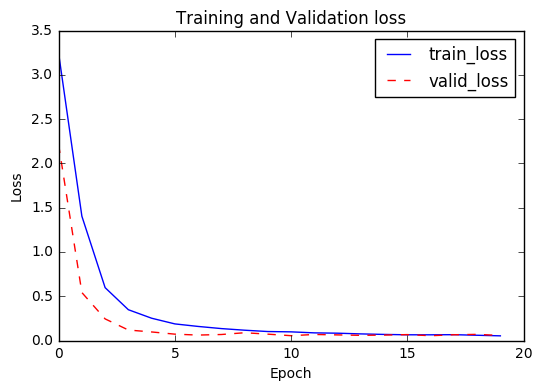

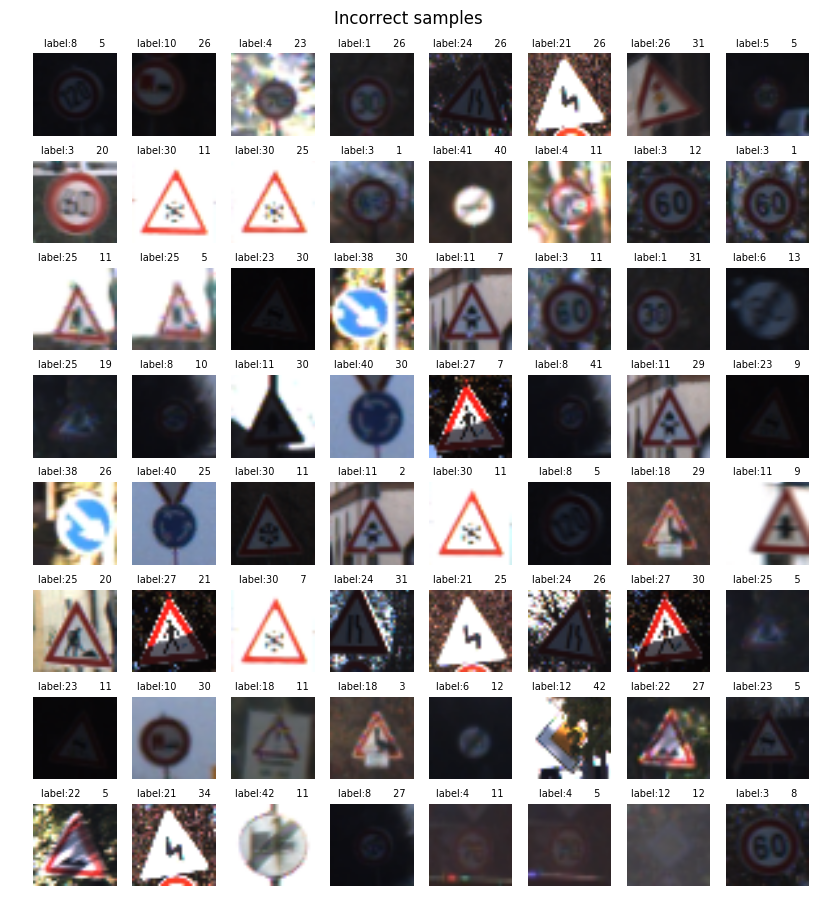

In [15]:
def show_fault_samples(images, labels, predicts, nb_grid=8, title=None):
    random_indices = [i for i in range(len(images))]
    np.random.shuffle(random_indices)
    images = images[random_indices]
    labels = labels[random_indices]

    fig, axes = plt.subplots(nb_grid, nb_grid, figsize=(10,10))
    fig.suptitle(title, fontsize=12)
    for i, start in enumerate(range(0, images.shape[0], int(images.shape[0]/nb_grid + 0.5))):
        end = start + nb_grid
        if end >= images.shape[0]:
            end -= images.shape[0]
        for j, (image, label, predict) in enumerate(zip(images[start:end],labels[start:end], predicts[start:end])):
            axes[i,j].set_title("label:{}       {}".format(label, predict), fontsize=7)
            axes[i,j].axis('off')
            axes[i,j].imshow(image)
    
    fig.subplots_adjust(top=0.94, bottom=0.1)
    plt.show()
    
    
# Test the model and check accuracy
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: {}'.format(score[1]))
    
# Plot loss history
train_loss_hist = hist.history['loss']
valid_loss_hist = hist.history['val_loss']

plt.plot(train_loss_hist, 'b', label='train_loss')
plt.plot(valid_loss_hist, '--r', label='valid_loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot incorrect cases
predict = model.predict(X_test)
arg_predict = np.argmax(predict, axis=1)
incorrect_indices = np.not_equal(arg_predict, _y_test)

incorrect_X = _X_test[incorrect_indices]
incorrect_y = _y_test[incorrect_indices]
incorrect_predict = arg_predict[incorrect_indices]
show_fault_samples(incorrect_X, incorrect_y, incorrect_predict, title='Incorrect samples')

In [16]:
from keras.metrics import top_k_categorical_accuracy

#inTop5 = lambda x, y: top_k_categorical_accuracy(x, y, k=5)

k = 5
for i in range(k):
    # Show top-k accuracy of the validation set
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[lambda x, y: top_k_categorical_accuracy(x, y, k=i+1)])
    score = model.evaluate(X_valid, y_valid, verbose=0)
    print('Top-{} valid accuracy: {}'.format(i+1, score[1]))

print()

for i in range(k):
    # Show top-k accuracy of the validation set
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[lambda x, y: top_k_categorical_accuracy(x, y, k=i+1)])
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Top-{} test accuracy: {}'.format(i+1, score[1]))

Top-1 valid accuracy: 0.9823129253592892
Top-2 valid accuracy: 0.9922902494331066
Top-3 valid accuracy: 0.9945578231292517
Top-4 valid accuracy: 0.9963718820861678
Top-5 valid accuracy: 0.9984126984126984

Top-1 test accuracy: 0.971654790229299
Top-2 test accuracy: 0.9869358670305658
Top-3 test accuracy: 0.9917656374468468
Top-4 test accuracy: 0.9939825812314865
Top-5 test accuracy: 0.9957244656337034
